In [104]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [105]:
data_path = '/Users/t08/works/deep_advance/data/catanddog/train/'
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform= transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers= 0,
    shuffle= True
)
print(len(train_dataset))

385


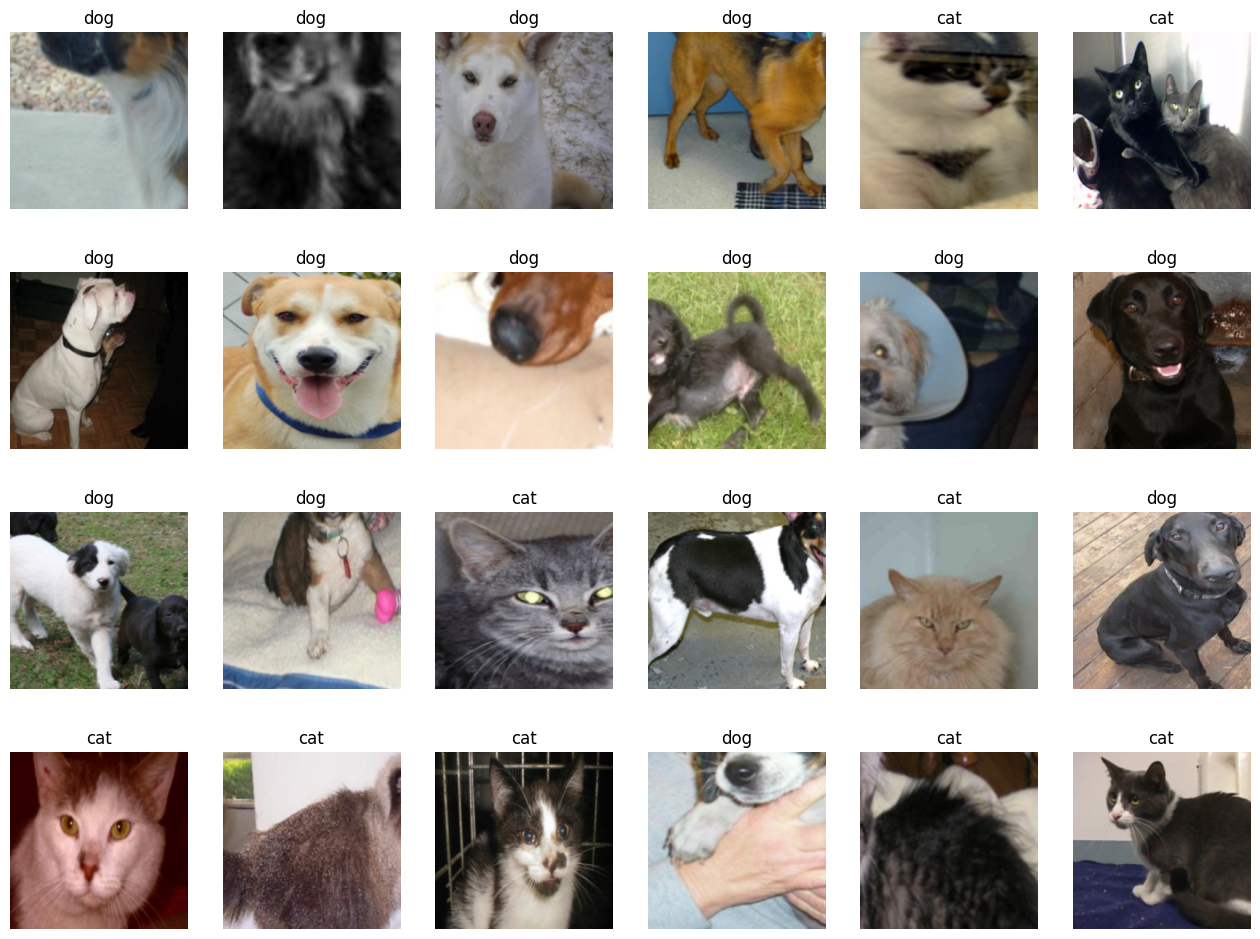

In [106]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top = 0.6, hspace=0)


In [107]:
resnet18 = models.resnet18(pretrained = True)

In [108]:
def set_parameter_requires_grad(model, feature_extracting =True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
set_parameter_requires_grad(resnet18)

In [109]:
resnet18.fc = nn.Linear(512,2)

In [110]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)


fc.weight tensor([[ 0.0050, -0.0292,  0.0055,  ..., -0.0410, -0.0104,  0.0242],
        [-0.0259, -0.0085,  0.0267,  ..., -0.0240, -0.0060, -0.0337]])
fc.bias tensor([0.0109, 0.0300])


In [111]:
model =models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [112]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs =model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss : {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/Users/t08/works/deep_advance/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [113]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [114]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch0/12
----------
Loss : 0.5777 Acc: 0.6857

Epoch1/12
----------
Loss : 0.4357 Acc: 0.8156

Epoch2/12
----------
Loss : 0.3787 Acc: 0.8338

Epoch3/12
----------
Loss : 0.3364 Acc: 0.8623

Epoch4/12
----------
Loss : 0.2668 Acc: 0.9065

Epoch5/12
----------
Loss : 0.2606 Acc: 0.9065

Epoch6/12
----------
Loss : 0.2473 Acc: 0.9091

Epoch7/12
----------
Loss : 0.2358 Acc: 0.9091

Epoch8/12
----------
Loss : 0.2552 Acc: 0.8779

Epoch9/12
----------
Loss : 0.3025 Acc: 0.8675

Epoch10/12
----------
Loss : 0.1882 Acc: 0.9351

Epoch11/12
----------
Loss : 0.2019 Acc: 0.9195

Epoch12/12
----------
Loss : 0.2880 Acc: 0.8675

Training complete in 1m 58s
Best Acc: 0.935065


In [115]:
test_path = '/Users/t08/works/deep_advance/data/catanddog/test/'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [116]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/Users/t08/works/deep_advance/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)
    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [117]:
val_acc_hist = eval_model(resnet18, test_loader, device)


saved_model ['/Users/t08/works/deep_advance/data/catanddog/00.pth', '/Users/t08/works/deep_advance/data/catanddog/01.pth', '/Users/t08/works/deep_advance/data/catanddog/02.pth', '/Users/t08/works/deep_advance/data/catanddog/03.pth', '/Users/t08/works/deep_advance/data/catanddog/04.pth', '/Users/t08/works/deep_advance/data/catanddog/05.pth', '/Users/t08/works/deep_advance/data/catanddog/06.pth', '/Users/t08/works/deep_advance/data/catanddog/07.pth', '/Users/t08/works/deep_advance/data/catanddog/08.pth', '/Users/t08/works/deep_advance/data/catanddog/09.pth', '/Users/t08/works/deep_advance/data/catanddog/10.pth', '/Users/t08/works/deep_advance/data/catanddog/11.pth', '/Users/t08/works/deep_advance/data/catanddog/12.pth']
Loading model /Users/t08/works/deep_advance/data/catanddog/00.pth
Acc: 0.7959

Loading model /Users/t08/works/deep_advance/data/catanddog/01.pth
Acc: 0.9286

Loading model /Users/t08/works/deep_advance/data/catanddog/02.pth
Acc: 0.9286

Loading model /Users/t08/works/deep

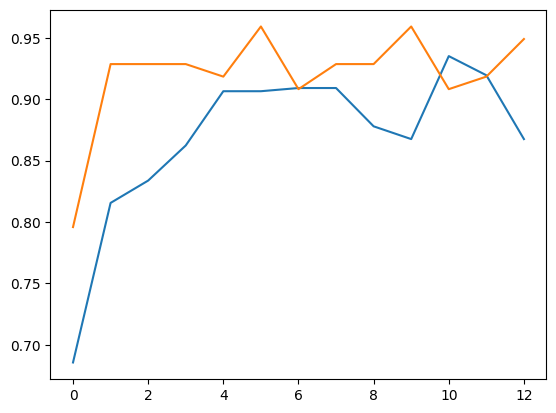

In [118]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

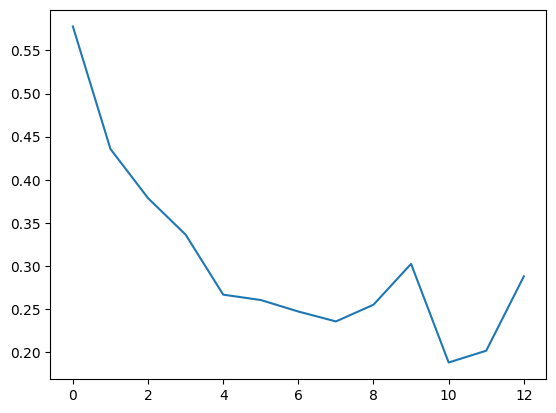

In [119]:
plt.plot(train_loss_hist)
plt.show()